This kernel is from https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python

# Introduction

In this notebook, I go over some visualizations of the iceberg data. My purpose here is not to set up a classifier, but rather to try to get some sense of what types of features might be most useful.

As usual, we first have to import some packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I'll now read in the file. It is in a .json format rather than the .csv format that seems to be most common on Kaggle. It also turns out that "inc_angle" has some bad values, so I will convert it to a floating point format with the NaN values left in.

In [2]:
train = pd.read_json('data/train.json')

# If ‘coerce’, then invalid parsing will be set as NaN
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')

In [3]:
train.shape

(1604, 5)

# Global Images Stats

Now, I will look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

In [4]:
train.head(3)

id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   

                                              band_2  inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...    43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...    38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...    45.2859           1

In [5]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]
    
    return train

train = get_stats(train,1)
train = get_stats(train,2)

## plotting the Statistics
Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

In [6]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


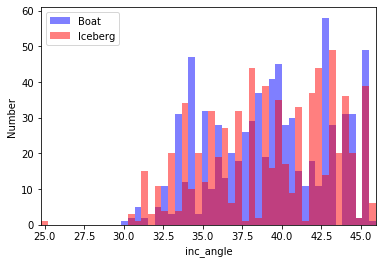

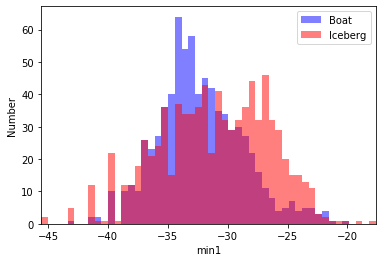

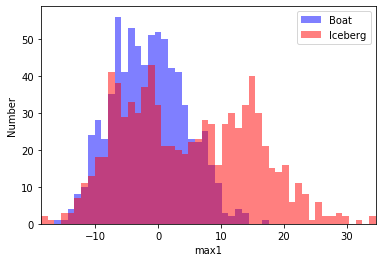

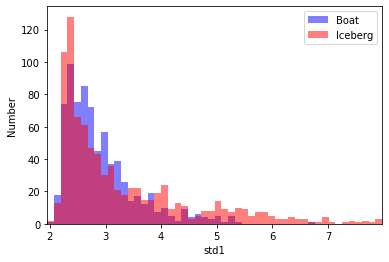

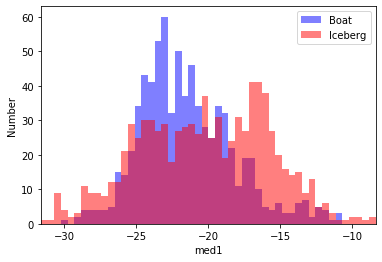

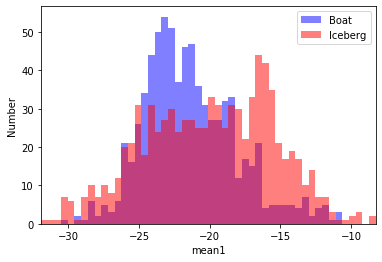

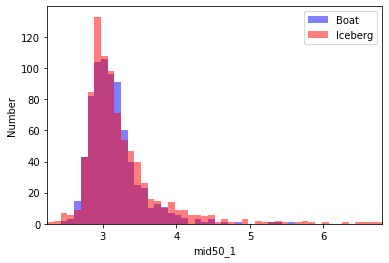

In [7]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col);

For the first band, we see that there are some significant differences. The middle 50% range has around the same size for both, but the minimum, maximum, standard deviation, median, and mean all show noticeable differences in some range of the values. Evidently, these basic variables seem to have some sensitivity to what we are trying to measure. We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

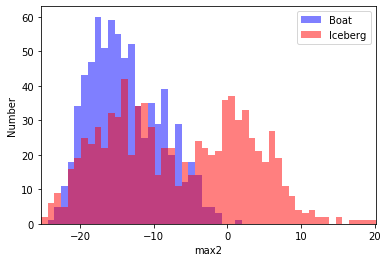

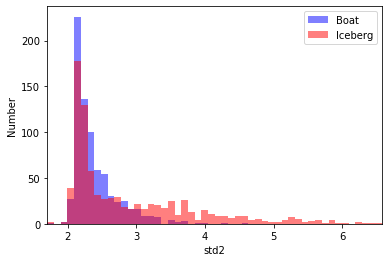

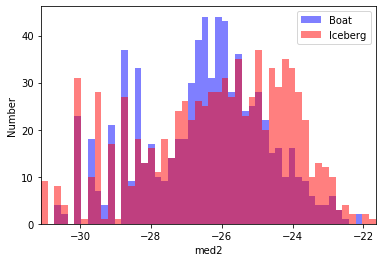

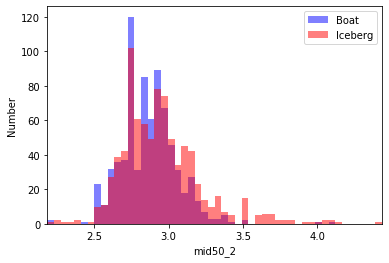

In [8]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col);

We get similar results for the second band.

## Correlations Between Features
Now that we've established that these variables may have some use, we should look at the correlations between them. For this, I'll just plot the correlation matrix. It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn), but i won't do that here.

In [9]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

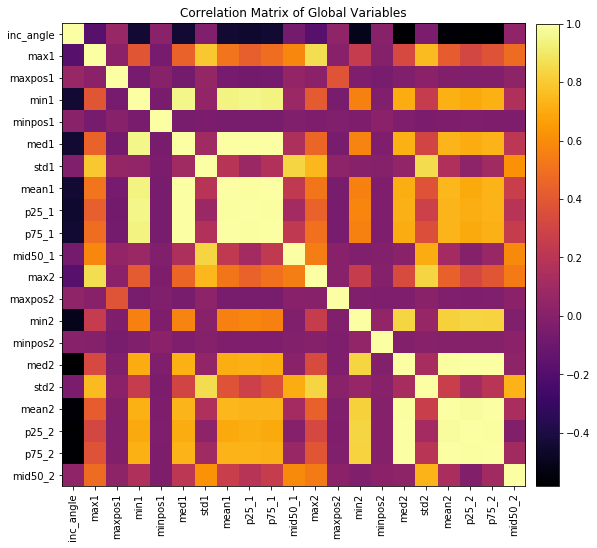

In [10]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10, 10))
plt.imshow(corr, cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels, train_stats.columns, rotation=90)
plt.yticks(labels, train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85, pad=0.02)
plt.show();

In [11]:
corr

inc_angle      max1   maxpos1      min1   minpos1      med1  \
inc_angle   1.000000 -0.178232  0.068786 -0.443299  0.017324 -0.444304   
max1       -0.178232  1.000000  0.020576  0.393628 -0.057418  0.450119   
maxpos1     0.068786  0.020576  1.000000 -0.059763  0.000406 -0.067837   
min1       -0.443299  0.393628 -0.059763  1.000000 -0.047070  0.951496   
minpos1     0.017324 -0.057418  0.000406 -0.047070  1.000000 -0.051957   
med1       -0.444304  0.450119 -0.067837  0.951496 -0.051957  1.000000   
std1       -0.023128  0.793234  0.057724  0.047600 -0.039513  0.100614   
mean1      -0.439042  0.515520 -0.060858  0.943673 -0.054244  0.995244   
p25_1      -0.444425  0.434082 -0.069257  0.954195 -0.050947  0.999092   
p75_1      -0.441886  0.492759 -0.061943  0.943676 -0.052541  0.996539   
mid50_1    -0.063108  0.583547  0.051279  0.074903 -0.022661  0.151685   
max2       -0.178178  0.866399  0.020230  0.410750 -0.036525  0.462242   
maxpos2     0.038773  0.009902  0.385123 -0.051204 -0.022815 -0.054948   
min2       -0.501426  0.252857 -0.025191  0.567491 -0.032124  0.572422   
minpos2     0.005027 -0.002075 -0.052824 -0.021526  0.019157 -0.026341   
med2       -0.576480  0.333157 -0.021004  0.708450 -0.029771  0.717997   
std2       -0.038368  0.758614  0.020724  0.249549 -0.037509  0.304288   
mean2      -0.564334  0.424791 -0.016705  0.721285 -0.036747  0.737711   
p25_2      -0.580218  0.319956 -0.021964  0.702043 -0.029257  0.709402   
p75_2      -0.569470  0.377880 -0.017901  0.717728 -0.033324  0.731515   
mid50_2     0.040507  0.482602  0.031724  0.160150 -0.034203  0.212360   

               std1     mean1     p25_1     p75_1  ...      max2   maxpos2  \
inc_angle -0.023128 -0.439042 -0.444425 -0.441886  ... -0.178178  0.038773   
max1       0.793234  0.515520  0.434082  0.492759  ...  0.866399  0.009902   
maxpos1    0.057724 -0.060858 -0.069257 -0.061943  ...  0.020230  0.385123   
min1       0.047600  0.943673  0.954195  0.943676  ...  0.410750 -0.051204   
minpos1   -0.039513 -0.054244 -0.050947 -0.052541  ... -0.036525 -0.022815   
med1       0.100614  0.995244  0.999092  0.996539  ...  0.462242 -0.054948   
std1       1.000000  0.194077  0.074640  0.169415  ...  0.740983  0.027768   
mean1      0.194077  1.000000  0.992243  0.998909  ...  0.522477 -0.051347   
p25_1      0.074640  0.992243  1.000000  0.993399  ...  0.446478 -0.055040   
p75_1      0.169415  0.998909  0.993399  1.000000  ...  0.501034 -0.053008   
mid50_1    0.833564  0.230316  0.116797  0.229948  ...  0.550019  0.008018   
max2       0.740983  0.522477  0.446478  0.501034  ...  1.000000  0.005237   
maxpos2    0.027768 -0.051347 -0.055040 -0.053008  ...  0.005237  1.000000   
min2       0.003641  0.565097  0.576752  0.562562  ...  0.253280 -0.024072   
minpos2   -0.002080 -0.025363 -0.025826 -0.026156  ... -0.000859 -0.028502   
med2       0.045792  0.713076  0.722314  0.709592  ...  0.340321 -0.025939   
std2       0.862838  0.381066  0.282618  0.358900  ...  0.837769  0.013343   
mean2      0.164770  0.743796  0.738813  0.737390  ...  0.441828 -0.023319   
p25_2      0.027502  0.702844  0.714351  0.699571  ...  0.324297 -0.026820   
p75_2      0.103971  0.731920  0.733981  0.727376  ...  0.389187 -0.024357   
mid50_2    0.618197  0.268214  0.192559  0.257806  ...  0.539011  0.018579   

               min2   minpos2      med2      std2     mean2     p25_2  \
inc_angle -0.501426  0.005027 -0.576480 -0.038368 -0.564334 -0.580218   
max1       0.252857 -0.002075  0.333157  0.758614  0.424791  0.319956   
maxpos1   -0.025191 -0.052824 -0.021004  0.020724 -0.016705 -0.021964   
min1       0.567491 -0.021526  0.708450  0.249549  0.721285  0.702043   
minpos1   -0.032124  0.019157 -0.029771 -0.037509 -0.036747 -0.029257   
med1       0.572422 -0.026341  0.717997  0.304288  0.737711  0.709402   
std1       0.003641 -0.002080  0.045792  0.862838  0.164770  0.027502   
mean1      0.565097 -0.025363  0.713076  0.381066  0.743796  0.702844   
p25_1   

We see that there are large correlations between some of the variables. In particular, the mean, median, 25% signal, and 75% signal are all closely related, with nearly 75% correlation. The min and max are also pretty highly correlated for band 1, as are the min and median for both bands, suggesting that the signals have maybe been scaled in some way to force this correlation. There are also some correlations between the two bands. Finally, we see an anticorrelation of around -0.5 between the mean of band 2 and the angle, with a weaker correlation for band 1.

## Plotting some images
It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands.

In [19]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

In [20]:
icebergs

id                                             band_1  \
733   4a57e4e6  [-24.409096, -23.279524, -22.865889, -19.82871...   
477   9ca2cf2a  [-20.308092, -18.846018, -20.907494, -22.80706...   
1371  83a70dd0  [-17.932524, -17.60478, -17.822002, -18.508152...   
1379  b2043476  [-23.188631, -23.188669, -22.545015, -25.18280...   
748   0f467f8a  [-17.332157, -16.918524, -18.461901, -17.65606...   
884   ad22c618  [-23.072798, -26.910564, -22.868528, -20.73070...   
1401  ffe4cfab  [-20.556051, -18.771648, -18.771648, -17.08529...   
525   fd6a4725  [-26.438282, -24.962599, -23.244347, -25.23844...   
968   96b89aba  [-25.53705, -24.976517, -23.038357, -23.483925...   

                                                 band_2  inc_angle  \
733   [-28.300589, -35.535202, -30.429806, -27.93108...    38.4591   
477   [-22.246292, -24.275513, -23.830051, -21.89192...    35.2984   
1371  [-24.410381, -24.89312, -24.410511, -25.947376...    36.4929   
1379  [-24.128563, -24.128601, -27.051201, -28.98944...    45.2851   
748   [-27.649633, -30.033419, -29.587952, -26.36064...    37.6866   
884   [-27.933559, -25.710606, -31.455498, -27.23848...    38.4752   
1401  [-26.425589, -28.439053, -28.439053, -25.30339...    37.7040   
525   [-29.490486, -29.960148, -30.98324, -28.621294...    44.5987   
968   [-29.974024, -29.058914, -28.231104, -31.55777...    43.9470   

      is_iceberg       max1  maxpos1       min1  minpos1       med1  ...  \
733            1   2.292634     3036 -33.258633     3543 -22.097952  ...   
477            1  14.086182     2215 -31.264038     1520 -18.031670  ...   
1371           1  -2.098128     2884 -31.168222     4233 -20.508835  ...   
1379           1   2.661673     2960 -33.428864     3284 -23.414564  ...   
748            1  -3.635550     2736 -28.006432     2721 -18.464067  ...   
884            1   1.641557     2972 -29.098057     4633 -19.281200  ...   
1401           1  -0.084476     2956 -29.233177     1195 -18.409765  ...   
525            1  -2.896784     2512 -34.238762     5562 -24.186554  ...   
968            1   0.005565     2967 -34.252316       92 -22.017687  ...   

           max2  maxpos2       min2  minpos2       med2      std2      mean2  \
733  -14.174173     2437 -39.975368     5569 -28.304567  2.577593 -28.417699   
477   -1.912501     2215 -36.791092     4173 -24.747513  3.198889 -24.498173   
1371 -16.887417     2735 -34.948700     2128 -24.414007  2.123383 -24.608460   
1379 -17.395361     2813 -35.928223     4870 -26.712168  2.173937 -26.833822   
748  -17.994913     2584 -37.550499     3944 -26.363281  2.150443 -26.500960   
884  -12.019272     2895 -35.540760      659 -26.290947  2.435113 -26.172549   
1401 -19.418077     2806 -36.590584     2490 -26.134102  2.095050 -26.303994   
525  -12.991475     3341 -38.166969     4797 -29.046299  2.850190 -28.873930   
968  -11.617718     2818 -39.517883     4825 -28.232004  2.566801 -28.116254   

          p25_2      p75_2   mid50_2  
733  -29.962650 -26.911568  3.051082  
477  -26.331203 -23.205006  3.126197  
1371 -25.948801 -23.108349  2.840452  
1379 -28.163490 -25.468472  2.695018  
748  -27.653965 -24.981840  2.672125  
884  -27.582521 -24.908936  2.673585  
1401 -27.716024 -24.796202  2.919822  
525  -30.459221 -27.463161  2.996060  
968  -29.507069 -26.780951  2.726118  

[9 rows x 25 columns]

## Raw Images
The first set show 9 random icebergs using band 1.

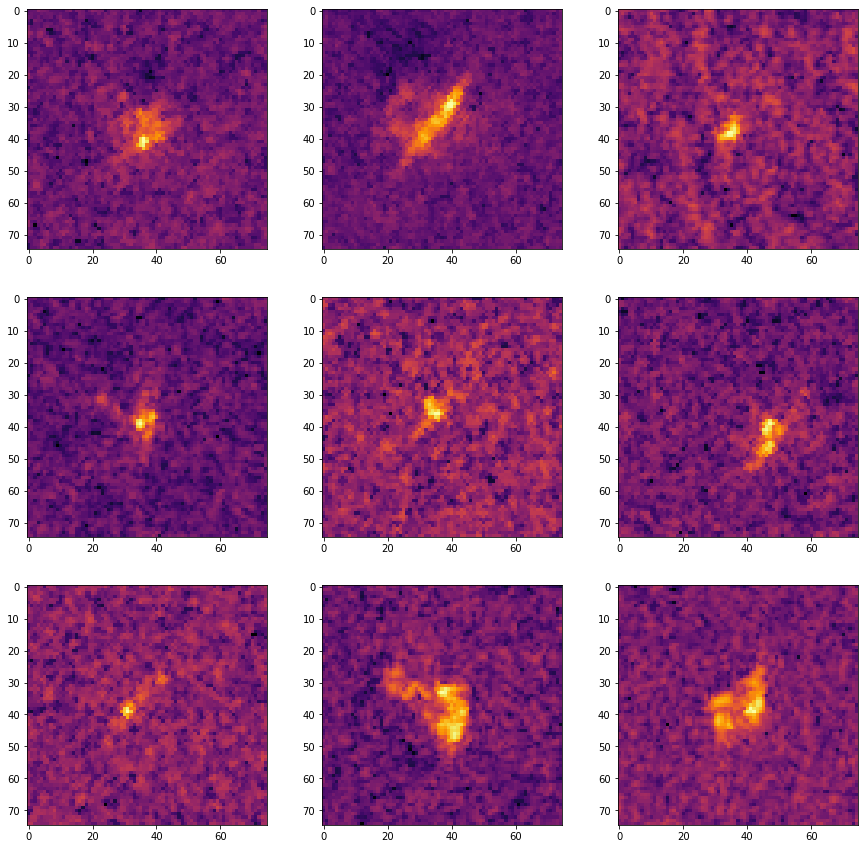

In [27]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The second set shows ships in band 1.

In [28]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The next set show the same set of icebergs in band 2.

In [29]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,2]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

Finally, the last set are the same ship images as before, but for band 2.

In [30]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,2]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

# Transforming the Images
I'll look at a few types of basic transforms that can be easily defined by FIR filters. The scipy convolve2d function will run a convolution of two arrays, so we just need to define the kernels. I have not optimized the kernels here, and there are many other choices of types of kernels, so you should try out different options to see what they do.

In [31]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

## Smoothing
First, let's try smoothing the images. The kernel here just has all positive values and is symmetric in both directions.

I'll first plot the icebergs and then the ships. These are all for Band 1.

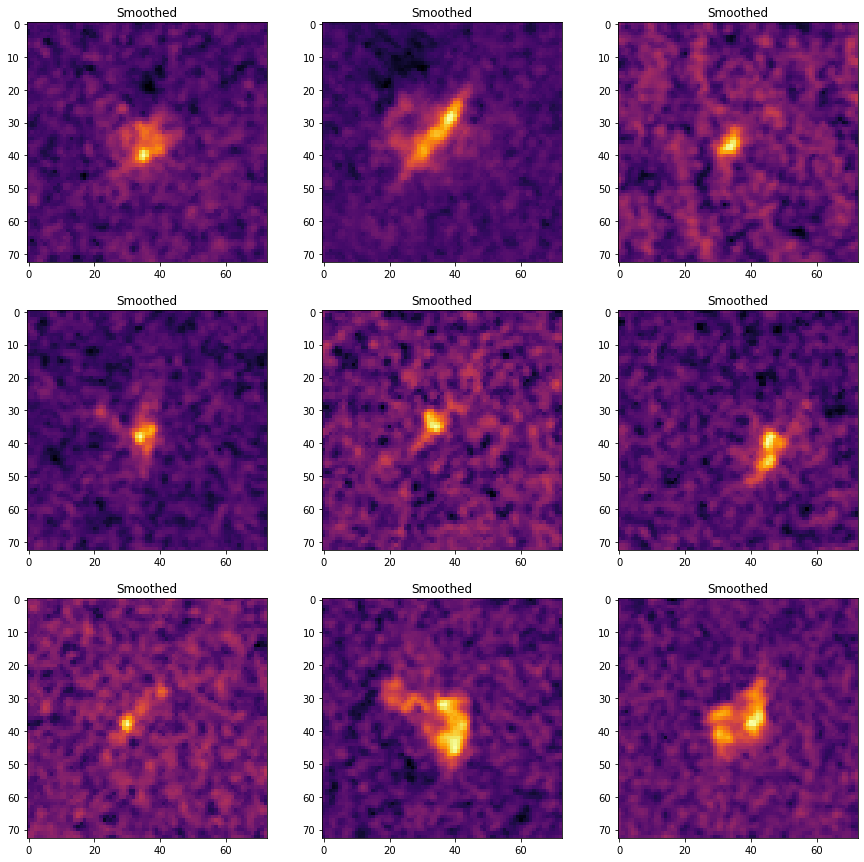

In [33]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

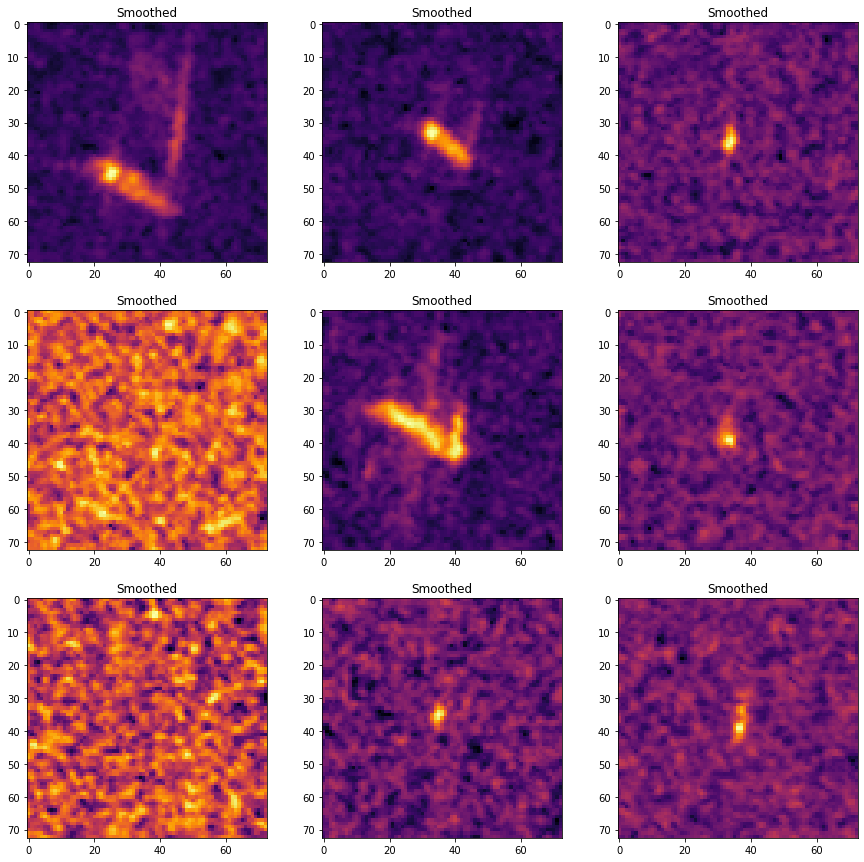

In [34]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,2]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

As we might expect, smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters in a cluster/peak finder.

## Derivative with respect to X
An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. This will provide some level of edge detection in the x-direction. I will take the derivatives of the original images.

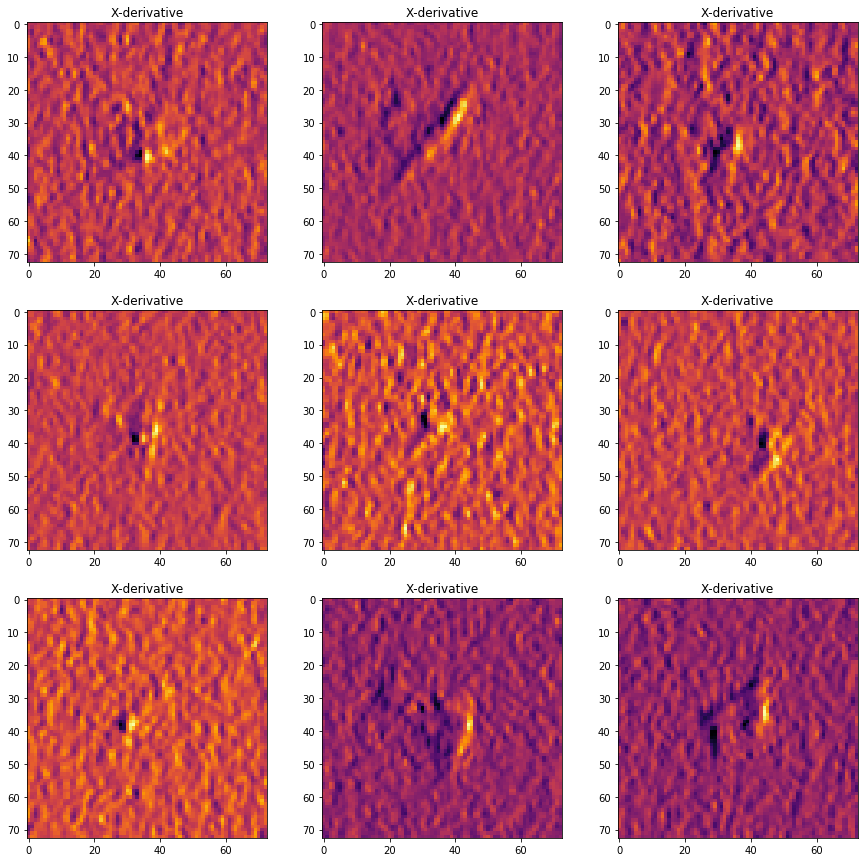

In [35]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

In [40]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

Note that you should see a dark region on the left side of a peak and a bright region on the right. If you look closely enough, you should see that the positions may have changed in all of these transformations. This is because I have chosen not to zero-pad the arrays. The resulting transformed arrays are slightly smaller than the input.

## Gradient Magnitude
It should also be trivial to see how to do a y-derivative. Rather than that, we can look at the magnitude of the gradient. That is, treat the x and y derivatives as a gradient vector at each position and then take the magnitude at each point.

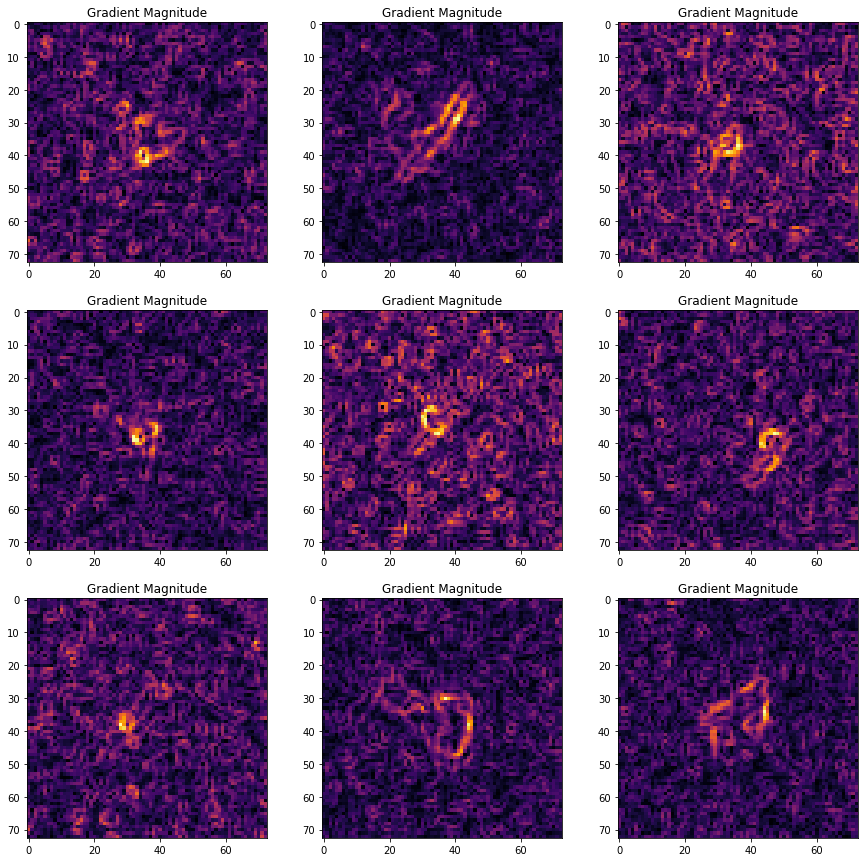

In [37]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

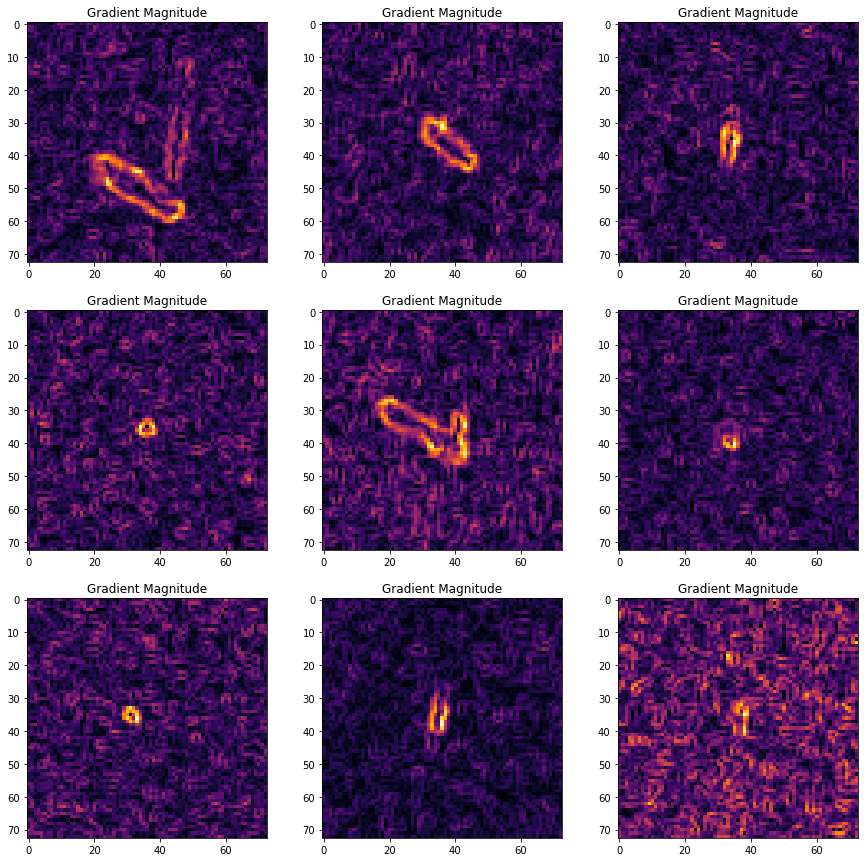

In [39]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

We see interesting circular shapes everywhere in these images. But, the signals look fairly strong. The ships, in particular, show fairly bright edges and most create nice loops. This sort of operator might be useful to put into a more advanced model like a neural net. At the very least, it would be good to compare the results using this against things like the raw and smoothed data.

## Second Derivatives
We can also define a simple second-derivative operator. A 3x3 second derivative should do less smoothing than a 3x3 first derivative, so we might see less contrast between the signal and the background.

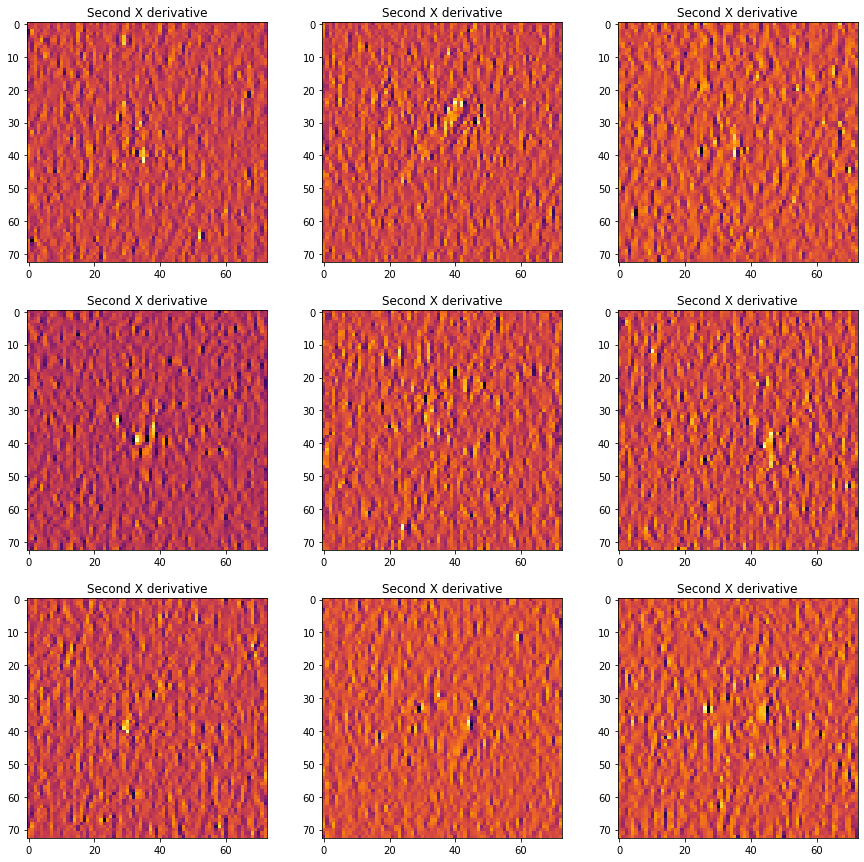

In [41]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

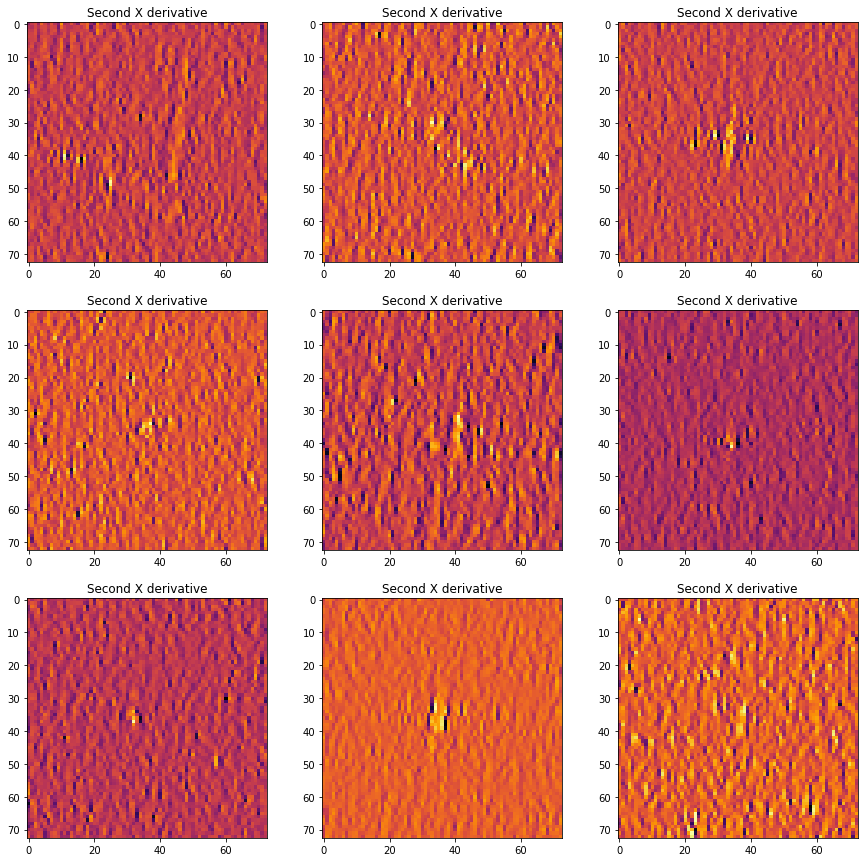

In [42]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

Here, we do see that the signals are not particularly obvious. The ships are a bit more visible, but the noise looks like it may be quite problematic here unless we do more smoothing.

## Laplacian
The Laplacian operator is just the sum of second derivatives, or the divergence of the gradient.

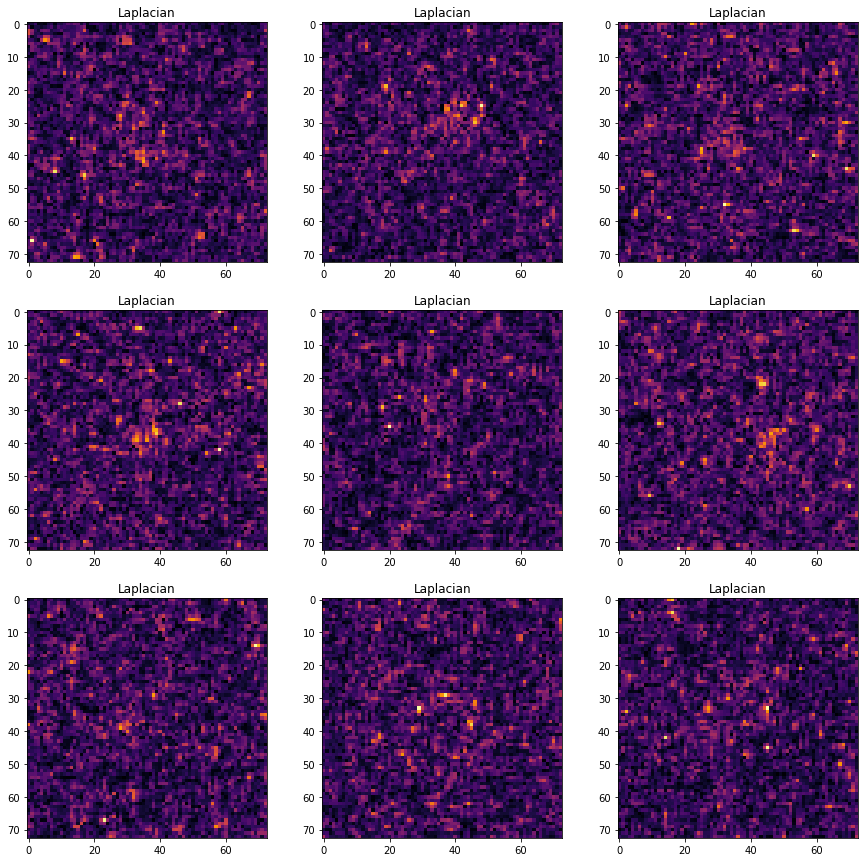

In [43]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')
    
plt.show()

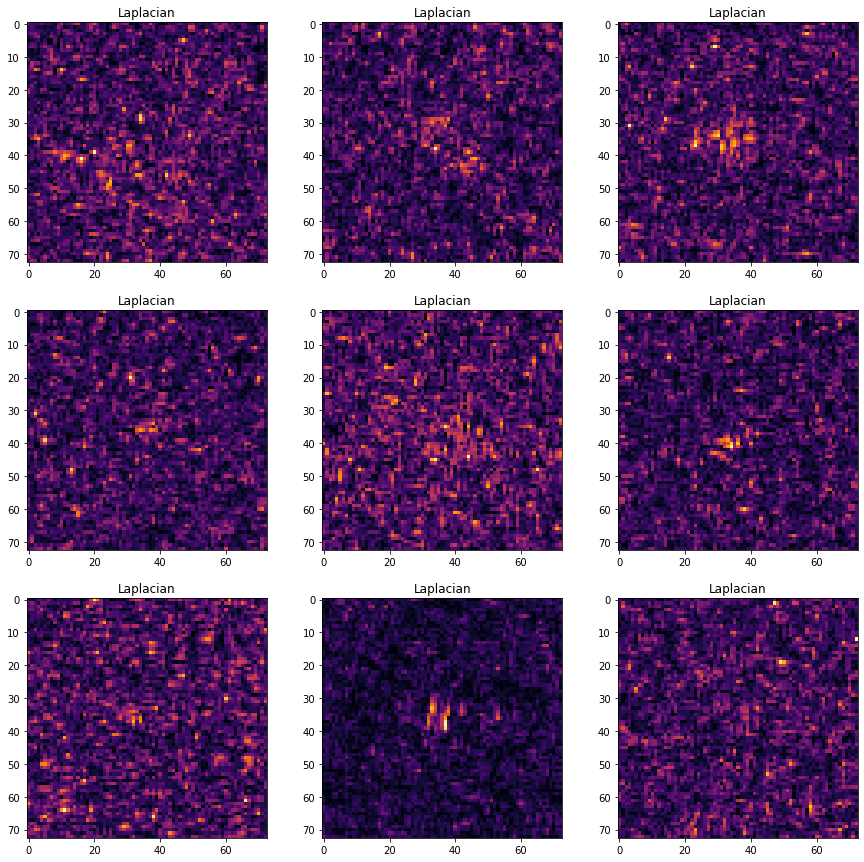

In [44]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')
    
plt.show()

We see interesting vertical and horizontal line features in the Laplacian images, but the signals are mostly difficult to see and split into many small clusters. Again, second derivatives probably require more smoothing to be useful.

## Magnitude of the Curl of Gradient
There are many other things that we can look at. The last one I'll do is the magnitude of the curl of the gradient. For a differentiable function, this actually is supposed to be exactly 0, but for our discrete images, this likely isn't the case. I wouldn't expect this to be useful though.

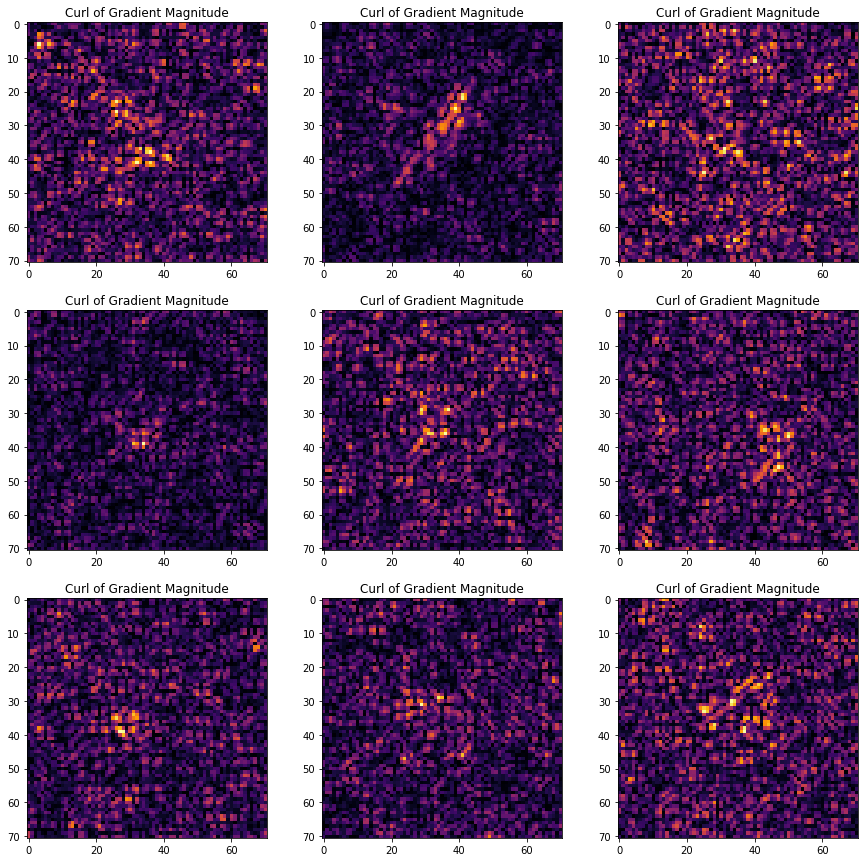

In [45]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()

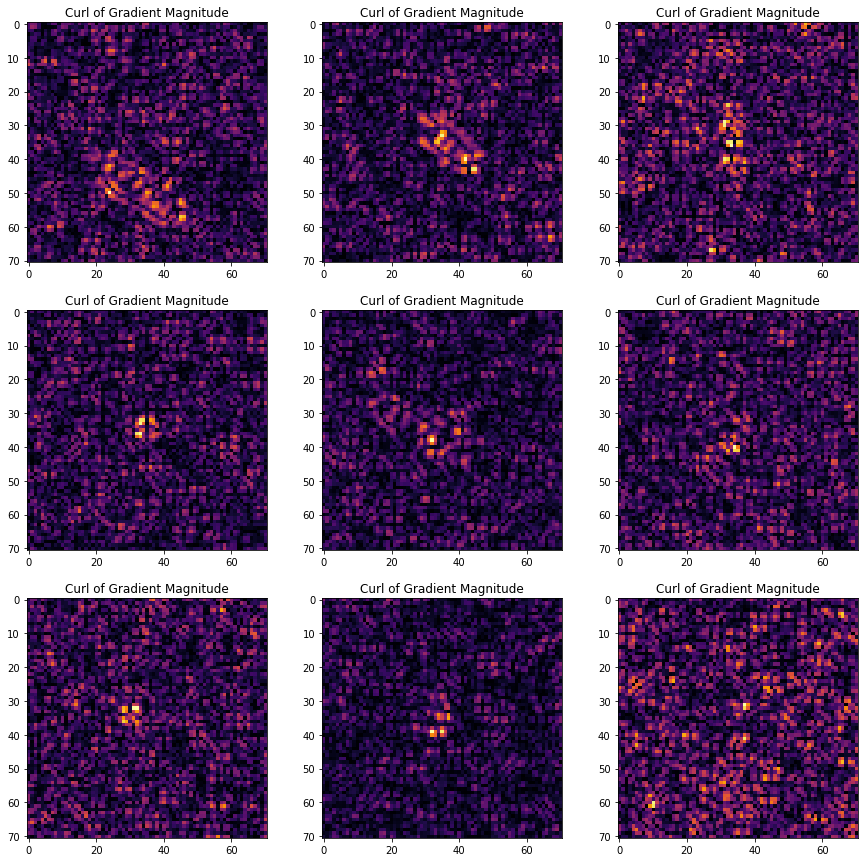

In [46]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()

We can see that as expected, it will at best be of limited usefulness. However, we do get some nice looking images. we see a number of small, separated tiles. Even if it's not useful for analysis, we get some nice textures by transforming the images with this particular transformation.

# Conclusions
We've constructed some global features from the images and found that there are some noticeable differences between icebergs and ships even just from those. However, I would expect that a classifier based only on global statistics will not be very effective.

We've also looked at a number of transformations of the images. Edge detection (gradient)-based methods seem to get some nice features, and smoothing may help out with images with small signal size.